pacotes

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from yahooquery import Ticker

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

### série históricas: PETR4 e BRENT

In [3]:
petr = Ticker("PETR4.SA")
petr4 = petr.history(period="max").loc[:,['close']].reset_index().drop('symbol', axis=1)
petr4['date'] = pd.to_datetime(petr4['date'], format="%Y-%m-%d")
petr4.set_index('date', inplace=True)

In [4]:
url_brent = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=1650971490&module=M'
pagina_brent = pd.read_html(url_brent)
brent = pagina_brent[2]
brent.columns = ['data','preço']
brent = brent.drop(0)
brent['preço'] = pd.to_numeric(brent['preço'])
brent['preço'] = brent['preço']/100
brent['data'] = pd.to_datetime(brent['data'], format="%d/%m/%Y")
brent.set_index('data', inplace=True)


In [5]:
brent = brent[brent['preço'].index >= petr4.index[0]]

In [6]:
brent.sort_index(inplace=True)

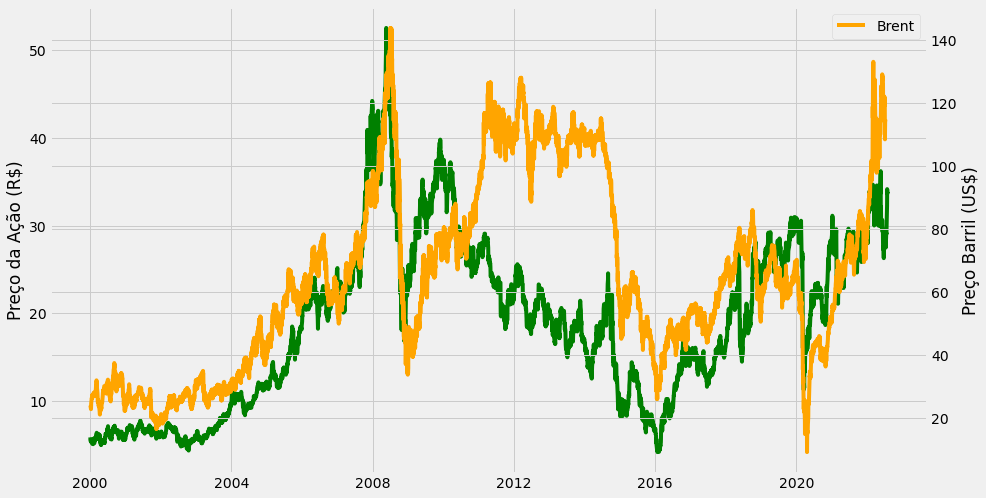

In [59]:
plt.style.use('fivethirtyeight')
afig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

ax1.plot(petr4['close'], label='PETR', color='green')
ax2.plot(brent['preço'], label='Brent', color='orange')
#plt.axvline(pd.Timestamp("2006-06-01"), label="Descoberta do Pré-sal", ls='--', color="black")
#plt.axvline(pd.Timestamp("2007-07-01"), label="ínicio da Crise do Subprime", ls='--', color="blue")
#plt.axvline(pd.Timestamp("2016-06-01"), label="Posse de Pedro Parente", ls='--', color="Grey")
#plt.axvline(pd.Timestamp("2020-02-01"), label="ínicio da crise do Covid-19", ls='--', color='green')
ax1.set_ylabel('Preço da Ação (R$)')
ax2.set_ylabel("Preço Barril (US$)")
plt.xlabel('Data')
plt.legend()
plt.show()


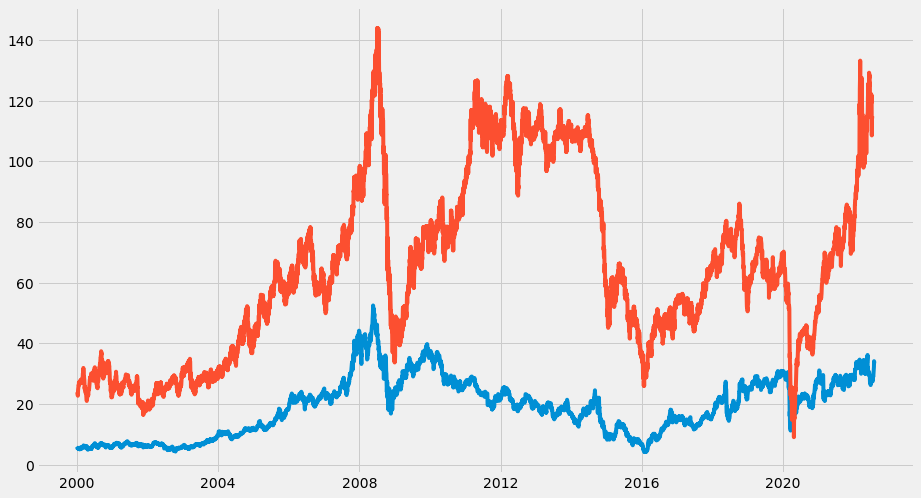

In [35]:
#Plot petr4 on y axis and brent on x axis to compare
ax, fig = plt.subplots(figsize=(14,8))
plt.plot(petr4['close'], label='PETR4')
plt.plot(brent['preço'], label='Brent')


In [91]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(brent.asfreq('b').dropna(), model='additive')

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [88]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(petr4['close'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.2237760725282465
p-valor:0.197729549481943


In [89]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(petr4, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=8.48 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=13236.378, Time=0.27 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=11645.099, Time=0.68 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=2.58 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=13234.310, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=10961.087, Time=1.10 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=8.94 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=4.89 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=10959.369, Time=0.63 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=11644.204, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=3.68 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=10961.077, Time=1.00 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=7.30 sec
 ARIMA(0,1,0)(2,1,0)[6] intercept   : AIC=10961.354, Time=2.2

In [90]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(petr4,order=(0,1,0),  seasonal_order=(2,1,0,6))
resultado_sarimax = model.fit()

C:\Users\est.matheus.brasil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\est.matheus.brasil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [91]:
# resultados do modelo SARIMAX(2,1,2)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             close   No. Observations:                 5674
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 6)   Log Likelihood               -5476.685
Date:                           Mon, 01 Aug 2022   AIC                          10959.369
Time:                                   16:49:41   BIC                          10979.297
Sample:                                        0   HQIC                         10966.309
                                          - 5674                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.6630      0.007    -98.544      0.000      -0.676      -0.650
ar.S.L12      -0.3380      0.006    -53.398      0.000      -0.350      -0.326
sigma2         0.4043      0.003    136.115      0.000       0.398       0.410
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):             32032.91
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               6.76   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [93]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(26.249611176944246, 28.742058474437815)

In [94]:
predicao_media[0]

27.49583482569103

In [95]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(petr4.index)

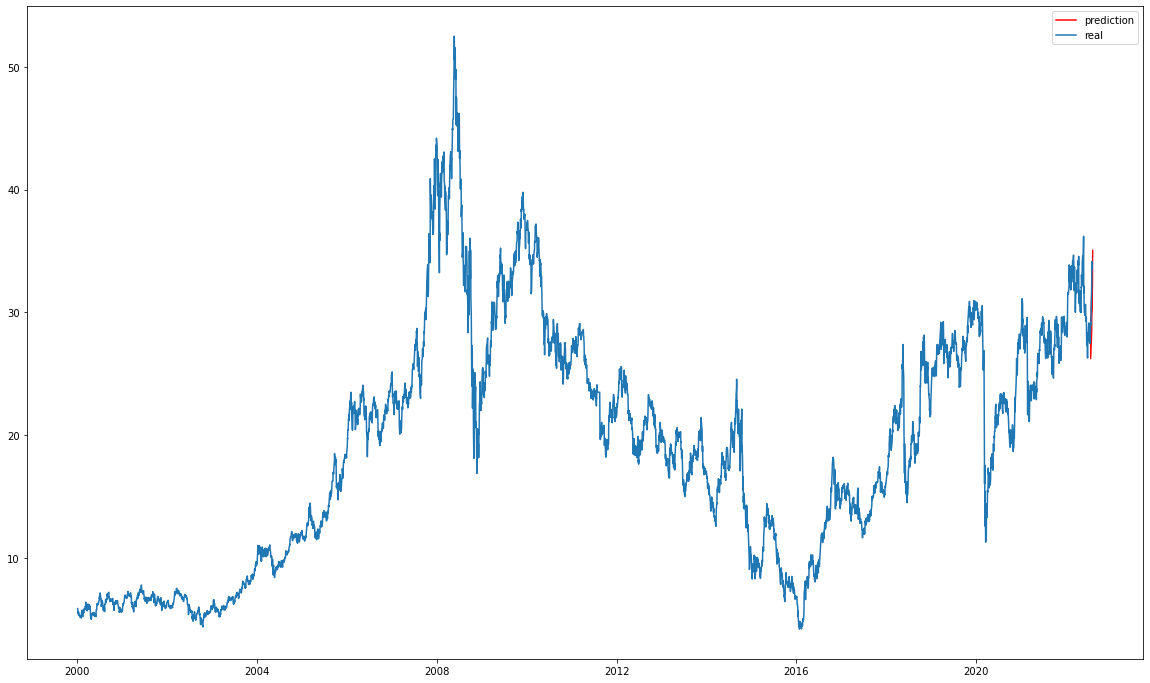

In [96]:
plt.figure(figsize=(20,12))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, petr4.values, label='real')
plt.legend()
plt.show()

In [97]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(petr4[-12:].values,predicao_media.values))
print(rmse_sarima)

0.8435382974739046


In [98]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

C:\Users\est.matheus.brasil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


12

In [99]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f, intervalo_acima_f

(5674    33.201984
 5675    33.106425
 5676    32.966121
 5677    32.800408
 5678    33.091041
 5679    32.470156
 5680    32.948503
 5681    33.028774
 5682    33.076937
 5683    33.117413
 5684    33.571014
 5685    33.084344
 Name: lower close, dtype: float64,
 5674    35.694431
 5675    36.631278
 5676    37.283167
 5677    37.785302
 5678    38.664322
 5679    38.575380
 5680    39.903983
 5681    40.741337
 5682    41.478637
 5683    42.155858
 5684    43.204208
 5685    43.277645
 Name: upper close, dtype: float64)

In [100]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

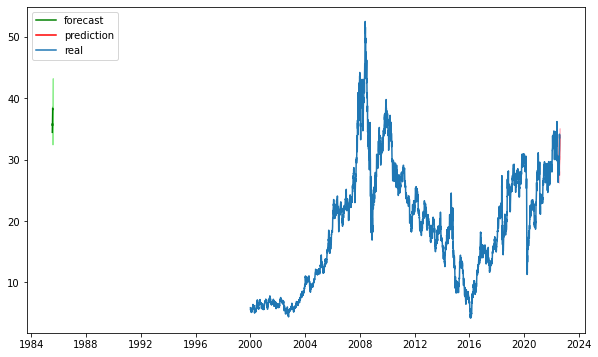

In [101]:
dates=np.asarray(petr4.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,petr4.values, label='real')
plt.legend(loc='upper left')
plt.show()